# Data Transormation

## Install/Import packages & define key varribles and functions

In [33]:
# Run install script
# %chmod +x setup_jupyterlab.sh
# %./setup_jupyterlab.sh

# Import necessary libraries for the script to function.
import pandas as pd
import csv, json, re, os, venn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

from functools import partial
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import _settings as settings
global spec_translate_list

spec_translate_list = settings.SPEC_TRANSLATE_LIST

# Set the default font to Calibri
#matplotlib.rcParams['font.family'] = 'Calibri'

def find_species(header, spec_translate_list):
    """Search for a species in the header and return the first element (species name) from the list."""
    header_lower = header.lower()
    for spec_group in spec_translate_list:
        for term in spec_group[1:]:  # Iterate over possible species names/terms except the first element
            if term.lower() in header_lower:
                return spec_group[0]  # Return the first element of the list (main species name)
    return "unknown"  # Return unknown if no species match is found

def parse_headers():
    fasta_dict = {}
    with open("protein_headers.txt", 'r') as file:
        protein_id = ""
        protein_name = ""
        species = ""
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if protein_id:
                    # Save the previous protein entry in the dictionary
                    fasta_dict[protein_id] = {
                        "name": protein_name,
                        "species": species
                    }
                sequence = ""
                header_parts = line[1:].split('|')
                if len(header_parts) > 2:
                    protein_id = header_parts[1]
                    protein_name_full = re.split(r' OS=', header_parts[2])[0]
                    if ' ' in protein_name_full:

                        protein_name = protein_name_full#.split()[1]
                    else:
                        protein_name = protein_name_full
                    # Find species in the header
                    species = find_species(line, spec_translate_list)

        if protein_id:
            # Save the last protein entry in the dictionary
            fasta_dict[protein_id] = {
                "name": protein_name,
                "species": species
            }
    return fasta_dict
proteins_dic = parse_headers()


## Group data by Catagorical Varriables

In [41]:
# Automatically load group_data.json from the specified directory
file_path = os.path.join('example_group_definition.json')
if os.path.exists(file_path):
    with open(file_path, 'r') as json_file:
        group_data = json.load(json_file)
    print(f"Loaded group data from {file_path}")
    print(f"{len(group_data)} groups imported from file")

else:
    print(f"File {file_path} does not exist. Please check the path.")
    print(f"Importing group data from defined in earlier in the current session ")
    from my_functions_datatransformation import group_data
group_data = {key: group_data[key] for key in list(group_data.keys())[0:4]}

Loaded group data from example_group_definition.json
6 groups imported from file


## Imports Proteome Discover Data

In [12]:
df = pd.read_csv(f'example_merged_dataframe.csv')
df.columns


Index(['unique ID', 'Sequence', 'Master Protein Accessions',
       'Positions in Proteins', 'start', 'stop',
       'Peptide Groups Peptide Group ID', 'Modifications', 'Theo MHplus in Da',
       'Sequence Length', 'Quan Info', 'E_7_2', 'E_5_7', 'E_8_7a', 'E_8_7b',
       'L_3_3', 'L_2_9', 'L_6_0', 'M_7_3', 'M_6_2', 'M_5_6', 'T_0_2a',
       'T_0_2b', 'T_0_2c', 'T_0_2d', 'Top Apex RT in min', 'search_peptide',
       'peptide', 'protein_id', 'protein_description', '% Alignment',
       'species', 'intervals', 'function', 'Avg_Threshold', 'Avg_Low',
       'Avg_Moderate', 'Avg_Extreme', 'Avg_Bitter', 'Avg_Non_bitter',
       'SEM_Threshold', 'SEM_Low', 'SEM_Moderate', 'SEM_Extreme', 'SEM_Bitter',
       'SEM_Non_bitter'],
      dtype='object')

In [15]:

# Get abundance columns
abundance_cols = [col for col in df.columns if 'Avg_' in col]

# Calculate total abundance
df['Total_Abundance'] = df[abundance_cols].sum(axis=1).astype(int)  # Changed .asint() to .astype(int)

# Create display DataFrame with just sequence and total
result_df = df[['unique ID', 'Total_Abundance']]

# Filter for Total_Abundance > 0
# Fixed the bracket placement in the boolean condition
result_df = result_df[result_df['Total_Abundance'] == 0]  

all_zero_list = list(result_df['unique ID'])
peptides_df=df[~df['unique ID'].isin(all_zero_list)]

peptides_df['Positions in Proteins']

0         P08037 [68-79]
1       P02668 [109-122]
3       P02666A2 [61-68]
4       P02666A1 [61-69]
5       P02666A1 [61-68]
              ...       
2094      P02754 [42-56]
2096      P02663 [82-88]
2097      P02663 [83-88]
2098    P02663 [191-196]
2099      P02662 [17-22]
Name: Positions in Proteins, Length: 1638, dtype: object

In [18]:
abundance_cols

['Avg_Threshold',
 'Avg_Low',
 'Avg_Moderate',
 'Avg_Extreme',
 'Avg_Bitter',
 'Avg_Non_bitter']

In [19]:
# List of additional columns to include
additional_columns = [
    'Master Protein Accessions',
    'Positions in Proteins',
    'unique ID'
]


# Select columns containing "Avg_" in their name
abundance_columns = [col for col in peptides_df.columns if 'Avg_' in col]
    
# Select columns containing "Avg_" in their name along with additional columns
selected_columns = additional_columns + abundance_columns

# Create a new DataFrame with the selected columns
new_df = peptides_df[selected_columns]

# Display the new DataFrame
new_df

,Master Protein Accessions,Positions in Proteins,unique ID,Avg_Threshold,Avg_Low,Avg_Moderate,Avg_Extreme,Avg_Bitter,Avg_Non_bitter
0,P08037,P08037 [68-79],AAIGQPSGELRL,1.993995e+05,NaN,NaN,NaN,NaN,1.993995e+05
1,P02668,P02668 [109-122],PPKKNQDKTEIPTI,1.433092e+06,3.890691e+05,2.216720e+05,1.085304e+05,1.537870e+05,9.110803e+05
3,P02666A2,P02666A2 [61-68],PFPGPIPN,1.799432e+07,5.870319e+07,2.433319e+08,2.752088e+08,2.615473e+08,3.834875e+07
4,P02666A1,P02666A1 [61-69],PFPGPIHNS,1.120372e+07,2.599340e+07,1.319396e+08,1.163283e+08,1.256951e+08,1.416166e+07
5,P02666A1,P02666A1 [61-68],PFPGPIHN,4.470104e+07,1.284110e+07,4.239515e+07,5.155861e+07,4.763141e+07,2.080608e+07
...,...,...,...,...,...,...,...,...,...
2094,P02754,P02754 [42-56],ASDISLLDAQSAPLR,9.923245e+04,NaN,NaN,NaN,NaN,9.923245e+04
2096,P02663,P02663 [82-88],LNEINQF,1.034155e+06,1.031478e+05,3.629807e+05,3.005979e+05,3.317893e+05,6.617521e+05
2097,P02663,P02663 [83-88],NEINQF,2.494915e+07,1.104465e+07,7.585204e+06,6.989255e+06,7.227635e+06,1.899008e+07
2098,P02663,P02663 [191-196],KPWLQP,4.488349e+06,5.217196e+07,3.977375e+07,3.998708e+07,3.989565e+07,2.492418e+07


In [20]:


# Create a new DataFrame with selected columns
new_df = peptides_df[abundance_columns + additional_columns]

# Calculate the sum of each "Avg_" column
total_sums = new_df[abundance_columns].sum()

# Create a DataFrame to store the sum for each "Avg_" column
sum_df = pd.DataFrame(total_sums, columns=['Total_Sum']).reset_index()

# Rename the columns for clarity
sum_df.columns = ['Sample', 'Total_Sum']

# Display the resulting DataFrame
sum_df

,Sample,Total_Sum
0,Avg_Threshold,7.836653e+10
1,Avg_Low,4.743366e+10
2,Avg_Moderate,3.005032e+10
3,Avg_Extreme,3.681531e+10
4,Avg_Bitter,3.464850e+10
5,Avg_Non_bitter,6.766540e+10


In [21]:
# Define a function to clean up the 'Positions in Proteins' column
def clean_positions(positions):
    # Remove [number-number] patterns using regex
    cleaned = re.sub(r'\[\d+-\d+\]', '', positions)
    # Replace semicolons with commas
    cleaned = cleaned.replace(';', ',')
    # Remove extra whitespace around commas and trim the string
    cleaned = re.sub(r'\s*,\s*', ',', cleaned).strip(',').strip()
    return cleaned

# Apply the cleaning function using .loc to avoid the warning
peptides_df.loc[:, 'Positions in Proteins'] = peptides_df['Positions in Proteins'].apply(clean_positions)


# Display the cleaned column (first few rows for verification)
set(peptides_df['Positions in Proteins'])


{'A5D7J7',
 'A5D980',
 'A5D9C4',
 'A5D9F9',
 'C6KGD8',
 'E1BAF5',
 'E1BCP6',
 'P02662',
 'P02663',
 'P02666A1',
 'P02666A2',
 'P02668',
 'P02754',
 'P02769',
 'P08037',
 'P10152',
 'P11151',
 'P18892',
 'P31096',
 'P80195',
 'P81265',
 'Q05688',
 'Q0VC14',
 'Q2KJJ1',
 'Q3T0W1',
 'Q4GZT3',
 'Q5E9H7',
 'Q8HXQ5'}

In [27]:


temp_df = peptides_df.copy()#[peptides_df['Marked as']=='Human']
# Define a function to replace entries in 'Positions in Proteins'

# Apply the function using .loc to avoid the warning
temp_df.loc[:, 'Protein_ID'] = temp_df['Positions in Proteins']

# Count peptides with multiple protein a cessions
num_multiple_entries = len(temp_df['Protein_ID'].str.contains(','))

unique_proteins = temp_df['Protein_ID'].dropna().unique()
multi_protein_combinations = [up for up in unique_proteins if ',' in up]
# Instructions for user actions
user_decisions = {}
decision_inputs = []

for combo in multi_protein_combinations:
    print(combo)
    for i in combo.split(','):
        named_combo = fetch_protein_names(i)
        occurrences = temp_df[temp_df['Protein_ID'].str.contains(i, regex=False)].shape[0]
        display(HTML(f"<b>{occurrences}</b> occurrences of <b>'{named_combo}'</b>."))
    
    



In [28]:
# Assuming `peptides_df` is your DataFrame

# Define the columns to keep
columns_to_keep = ['Master Protein Accessions']

proteins_df = pd.DataFrame()
# Group by 'Positions in Proteins' while keeping specific columns and summing the abundance columns
proteins_df = temp_df.groupby('Protein_ID').agg(
    {**{col: 'first' for col in columns_to_keep}, **{col: 'sum' for col in abundance_columns}}
).reset_index()


# Calculate the Relative Abundance for each abundance column
for col in abundance_columns:
    proteins_df[f'Rel_{col}']= (proteins_df[col] / sum(proteins_df[col])) * 100


# Function to clean column names
def clean_column_name(col):
    # Remove "Avg__" from the column name
    col = col.replace('Avg__', '')
    # Replace each key in the digestive_phase_mapping with its corresponding value


    return col

# Apply the cleaning function to all columns except for specific columns to keep unchanged
proteins_df.columns = [clean_column_name(col) if 'Avg_' in col else col for col in proteins_df.columns]


In [34]:
name_list = []
def fetch_protein_names_modified(accession_str):
    names = []
    species_set = set()  # To track the species present in the names

    for acc in accession_str.split('; '):
        if acc in proteins_dic:
            # Fetch species and the second part of the name (after splitting)
            name = proteins_dic[acc]['name'].split()[1]
            names.append(name)
        else:
            names.append(acc)
    
    # Remove duplicates while maintaining order
    unique_names = []
    for name in names:
        if name not in unique_names:
            unique_names.append(name)
    return names


# Iterate through each row in the DataFrame
for _, row in proteins_df.iterrows():
    # Check if the 'Protein_ID' contains a comma
    if ',' in row['Protein_ID']:
        # Split the string by commas and fetch protein names for each part
        strrow = row['Protein_ID'].split(',')
        named_combo = fetch_protein_names_modified('; '.join(strrow))  # Join the list as a single string with semicolons
    else:
        # Fetch protein name for a single protein ID
        named_combo = fetch_protein_names_modified(row['Protein_ID'])
    name_list.append(named_combo)

# Assign the combined names to a new 'Description' column
proteins_df['Description'] = name_list
# Ensure all values in the 'Description' column are strings, then remove square brackets
proteins_df['Description'] = proteins_df['Description'].astype(str).str.replace(r"['\['\]]", "", regex=True)


In [37]:

# Example usage (assuming proteins_df is already defined and contains columns with 'Rel_' prefix)

#plot_stacked_bar_simple(proteins_df)
# Step 1: Identify columns that contain 'Rel_HM' and those that start with 'Rel' but do not contain 'Rel_HM'

tem = proteins_df.copy()
# Step 2: Calculate the average for each set of columns

# Filter columns that start with "Rel"
rel_columns = proteins_df.columns[proteins_df.columns.str.startswith("Rel")]

tem['sum_avg'] = proteins_df[rel_columns].mean(axis=1)
# Step 3: Select relevant columns for the new DataFrame
new_df = tem[['Protein_ID', 'Master Protein Accessions', 'Description','sum_avg']]
#new_df = new_df[new_df['Description'].str.contains('Bovine') & new_df['Description'].str.contains('Human')]
# Display the new DataFrame
new_df_sorted = new_df.sort_values(by='sum_avg', ascending=False)

pro_list = list(new_df_sorted['Description'].head(n=15))

#other_list = ['Human - Alpha-lactalbumin','Bovine & Human - Lactotransferrin','Bovine & Human - Beta-casein','Bovine & Human - Osteopontin','Bovine - Osteopontin']
#pro_list += other_list
#for i in ['Human - Butyrophilin', 'Human - Polymeric', 'Bovine - Glycosylation-dependent']:
#    pro_list.remove(i)
# Strip square brackets from the 'Description' column

new_df_sorted.head(n=10)

,Protein_ID,Master Protein Accessions,Description,sum_avg
9,P02666A1,P02666A1,P02666A1,54.664246
7,P02662,P02662,Alpha-S1-casein,22.371119
8,P02663,P02663,Alpha-S2-casein,11.305341
10,P02666A2,P02666A2,P02666A2,10.167231
11,P02668,P02668,Kappa-casein,0.982186
19,P80195,P80195,Glycosylation-dependent,0.419888
18,P31096,P31096,Osteopontin,0.034664
5,E1BAF5,E1BAF5,Uncharacterized,0.018835
12,P02754,P02754,Beta-lactoglobulin,0.014662
4,C6KGD8,C6KGD8,Histatherin,0.008040


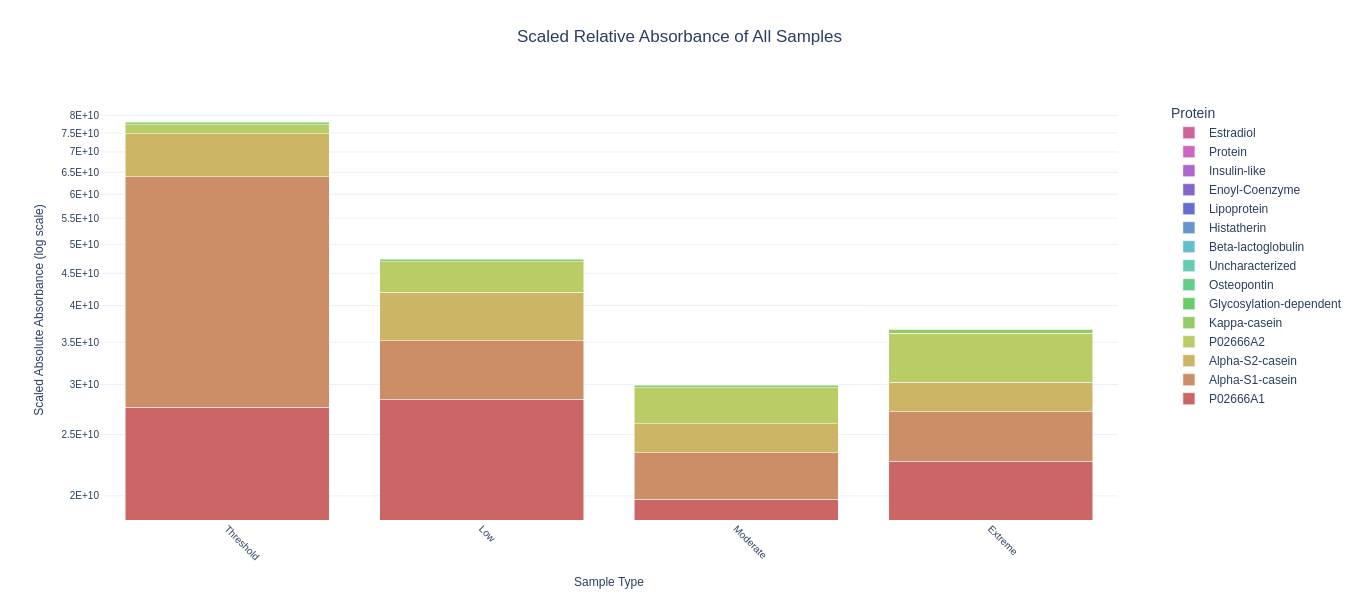

In [89]:
def plot_stacked_bar_scaled(proteins_df, sum_df, pro_list, title):
    import plotly.graph_objects as go
    import numpy as np
    
    scaled_df = proteins_df.copy()
    
    grouping_vars = [group_info['grouping_variable'] for group_info in group_data.values()]
    sample_orders = [f'Rel_Avg_{var}' for var in grouping_vars]
    
    sample_mapping = {
        'Rel_Avg_Threshold': 'Avg_Threshold',
        'Rel_Avg_Low': 'Avg_Low',
        'Rel_Avg_Moderate': 'Avg_Moderate',
        'Rel_Avg_Extreme': 'Avg_Extreme'
    }
    
    # Convert relative absorbance columns to percentages
    for col in sample_orders:
        scaled_df[col] = proteins_df[col] * 100  # Convert to percentage
        
    for col in sample_orders:
        sample_key = sample_mapping[col]
        total_sum = sum_df.loc[sum_df['Sample'] == sample_key, 'Total_Sum'].values[0]
        if total_sum > 0:
            scaled_df[col] = proteins_df[col] * total_sum / proteins_df[col].sum()
    
    fig = go.Figure()
    
    colors = [f'hsl({h},50%,60%)' for h in np.linspace(0, 330, len(pro_list))]
    for idx, row in scaled_df.iterrows():
        protein_description = row['Description']
        if protein_description in pro_list:
            color = colors[pro_list.index(protein_description)]
            
            hover_text = []
            for sample in sample_orders:
                abs_col = sample_mapping[sample]
                rel_value = proteins_df.loc[idx, sample] * 100  # Get percentage from original relative values
                abs_value = row[abs_col]
                hover_text.append(
                    f"Protein: {row['Master Protein Accessions']}<br>" +
                    f"Description: {row['Description']}<br>" +
                    f"Sample: {sample.replace('Rel_Avg_', '')}<br>" +
                    f"Relative Absorbance: {rel_value/100:.2f}%<br>" +
                    f"Absolute Absorbance: {abs_value:.2e}"
                )
            
            fig.add_trace(go.Bar(
                name=protein_description,
                x=[label.replace('Rel_Avg_', '') for label in sample_orders],
                y=row[sample_orders],
                marker_color=color,
                hovertext=hover_text,
                hoverinfo='text'
            ))
    
    fig.update_layout(
        barmode='stack',
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Sample Type",
        yaxis_title="Scaled Absolute Absorbance (log scale)",
        yaxis_type="log",
        legend_title="Protein",
        legend={
            'yanchor':"top",
            'y':1,
            'xanchor':"left",
            'x':1.05
        },
        showlegend=True,
        template='plotly_white',
        height=600,
        width=1000,
        margin=dict(t=100, l=100, r=200),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    
    fig.update_xaxes(
        tickangle=45,
        title_font={"size": 12},
        tickfont={"size": 10}
    )
    
    """    fig.update_yaxes(
            title_font={"size": 12},
            tickfont={"size": 10},
            exponentformat='E',  # Changed to 'E' format
            showexponent='all',  # Show exponent on all ticks
            dtick=1,
            tickformat='.0e'  # Format to ensure clean exponential notation
            )"""    
    fig.update_yaxes(
        title_font={"size": 12},
        tickfont={"size": 10},
        exponentformat='E',
        showexponent='all'
    )
    
    
    fig.show()

# Sort and prepare proteins_df based on pro_list
description_order = {desc: i for i, desc in enumerate(pro_list)}
proteins_df['Order'] = proteins_df['Description'].map(description_order)
proteins_df = proteins_df.sort_values(by='Order').drop(columns=['Order']).reset_index(drop=True)

# Example usage
plot_stacked_bar_scaled(proteins_df, sum_df, pro_list, 'Scaled Relative Absorbance of All Samples')